In [19]:
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
import random
from scipy.stats import probplot
from sklearn.model_selection import train_test_split
import seaborn as sns

import sys
sys.path.insert(0, "C:\\Users\\billy\\OneDrive\\Documents\\Python Scripts\\1. Portfolio\\machine-failure\\machine-failure")
import custom_funcs as cf

# Predicting type of machine failure

* Predicting machine failure through machine learning is paramount for efficient industrial operations. By analysing data patterns, ML models can forecast potential breakdowns, allowing for proactive maintenance and minimising downtime. This predictive approach not only enhances equipment reliability but also optimises resource allocation.

* This workbook details the exploration of [The AI4I 2020 Predictive Maintenance Dataset](https://archive.ics.uci.edu/dataset/601/ai4i+2020+predictive+maintenance+dataset). This is a synthetic that reflects real predictive maintenance data encountered in industry.

# Summary

Descriptive statistics and frequency distributions are computed for all variables during data exploration & cleansing. Key observations and actions are outlined below.

1. Erroneous Data
   
    * No duplicate rows are present.
    
    * Data exploration did not reveal any errors.
  
2. Distributions

    * A relatively uniform distribution is observed for Tool Wear
    
    * A positive skew is exhibited by Rotational Speed.
    
    * The Air Temperature, Process Temperature and Torque variables' distributions appear roughly normal.
  
    * No duplicate values are present in cust_unique_id.
    
    * The distributions of gender, ethnicity_group and geo_region are imbalanced.
    
    * One of the gender categories is called '999'. The meaning is unclear.
  
3. Missing values

    * No missing values are present.
  
4. Outliers

    * The Rotational Speed column has a positive skew. However, no outliers are obviously present.
    
        Note: The influence of large values on later modelling will be assessed. If a point significantly affects outcomes, it may be excluded.

# Import raw data

|Variable|Definition|
|---|---|
| UID | Unique identifier ranging from 1 to 10000 |
| productID | Consisting of a letter L, M, or H for low (50% of all products), medium (30%), and high (20%) as product quality variants and a variant-specific serial number |
| air temperature K | Generated using a random walk process later normalized to a standard deviation of 2 K around 300 K |
| process temperature K | Generated using a random walk process normalized to a standard deviation of 1 K, added to the air temperature plus 10 K. |
| rotational speed rpm | Calculated from power of 2860 W, overlaid with a normally distributed noise |
| torque Nm | Torque values are normally distributed around 40 Nm with an Ïƒ = 10 Nm and no negative values. |
| tool wear min | The quality variants H/M/L add 5/3/2 minutes of tool wear to the used tool in the process. |
| target | Failure or not. |
| Failure type | Type of failure. |

In [20]:
raw_df = pd.read_csv(cf.file_directory("raw") + "predictive_maintenance.csv")
raw_df.head()

,UDI,Product ID,Type,Air temperature [K],Process temperature [K],Rotational speed [rpm],Torque [Nm],Tool wear [min],Target,Failure Type
0,1,M14860,M,298.1,308.6,1551,42.8,0,0,No Failure
1,2,L47181,L,298.2,308.7,1408,46.3,3,0,No Failure
2,3,L47182,L,298.1,308.5,1498,49.4,5,0,No Failure
3,4,L47183,L,298.2,308.6,1433,39.5,7,0,No Failure
4,5,L47184,L,298.2,308.7,1408,40.0,9,0,No Failure


In [21]:
# Dimensions
print(f"Number of rows: {raw_df.shape[0]}")
print(f"Number of columns: {raw_df.shape[1]}")

Number of rows: 10000
Number of columns: 10


# Data exploration

## Variable types

**1) Categorical variables**

* Nominal variables = Categories or groups that have *no* inherent order or ranking.
  
* Ordinal variables = Categories or groups with a meaningful order or ranking.

    Note: It differs from the interval scale and ratio scale by not having category widths that represent equal increments of the underlying attribute

|Variable|Definition|Type|
|---|---|---|
| UID | Unique identifier ranging from 1 to 10000 | Nominal/ordinal |
| productID | Consisting of a letter L, M, or H for low (50% of all products), medium (30%), and high (20%) as product quality variants and a variant-specific serial number | Nominal |
| target | Failure or not. | Nominal |
| Failure type | Type of failure. | Nominal |

**2) Continuous variables**

* Interval variables = A quantitative scale with a meaningful order or ranking *and* equal distances between adjacent values.

    Note: It differs from a ratio variable in that zero is an arbitrary point, not a complete absence of the variable.

* Ratio variables = A quantitative scale with a meaningful order or ranking *and* equal distances between adjacent values *and* a true zero.

|Variable|Definition|Type|
|---|---|---|
| air temperature K | Generated using a random walk process later normalized to a standard deviation of 2 K around 300 K | Ratio |
| process temperature K | Generated using a random walk process normalized to a standard deviation of 1 K, added to the air temperature plus 10 K. | Ratio |
| rotational speed rpm | Calculated from power of 2860 W, overlaid with a normally distributed noise | Ratio |
| torque Nm | Torque values are normally distributed around 40 Nm with an Ïƒ = 10 Nm and no negative values. | Ratio |
| tool wear min | The quality variants H/M/L add 5/3/2 minutes of tool wear to the used tool in the process. | Ratio |

## Data types

* The data types for the 'UDI' feature is updated to categorical.

* The data type for the 'Target' feature is updated to object.

In [22]:
# Data types
display(raw_df.info())
print("\n")
display(raw_df.dtypes.value_counts())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 10 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   UDI                      10000 non-null  int64  
 1   Product ID               10000 non-null  object 
 2   Type                     10000 non-null  object 
 3   Air temperature [K]      10000 non-null  float64
 4   Process temperature [K]  10000 non-null  float64
 5   Rotational speed [rpm]   10000 non-null  int64  
 6   Torque [Nm]              10000 non-null  float64
 7   Tool wear [min]          10000 non-null  int64  
 8   Target                   10000 non-null  int64  
 9   Failure Type             10000 non-null  object 
dtypes: float64(3), int64(4), object(3)
memory usage: 781.4+ KB


None

int64      4
object     3
float64    3
Name: count, dtype: int64

In [23]:
# Check if cust_unique_id is a continuous sequence of integers
min_val, max_val = raw_df['UDI'].min(), raw_df['UDI'].max()
expected_sequence = set(range(min_val, max_val + 1))
print(f"Continuous: {set(raw_df['UDI'].unique()) == expected_sequence}")

# Update cust_unique_id -> categorical dtype
raw_df['UDI'] = pd.Categorical(raw_df['UDI'], categories=expected_sequence, ordered=True)

Continuous: True


In [24]:
# Update dtypes
raw_df['Target'] = raw_df['Target'].astype('object')

## Summary statistics

**_1) Continuous variables_**

* The mean and median values are similar for each variable. This suggests all continuous variables exhibit symmetric frequency distributions.

In [25]:
raw_df.select_dtypes(include=['number']).describe()

,Air temperature [K],Process temperature [K],Rotational speed [rpm],Torque [Nm],Tool wear [min]
count,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000
mean,300.004930,310.005560,1538.776100,39.986910,107.951000
std,2.000259,1.483734,179.284096,9.968934,63.654147
min,295.300000,305.700000,1168.000000,3.800000,0.000000
25%,298.300000,308.800000,1423.000000,33.200000,53.000000
50%,300.100000,310.100000,1503.000000,40.100000,108.000000
75%,301.500000,311.100000,1612.000000,46.800000,162.000000
max,304.500000,313.800000,2886.000000,76.600000,253.000000


**_2) Categorical variables_**

* No duplicate values are present in 'UDI' and 'Product ID'.

* The number of unique values in the Type, Target and Failure Type columns is relatively low.

In [26]:
raw_df.select_dtypes(include=['object', 'category']).describe()

,UDI,Product ID,Type,Target,Failure Type
count,10000,10000,10000,10000,10000
unique,10000,10000,3,2,6
top,1,M14860,L,0,No Failure
freq,1,1,6000,9661,9652


## Frequency distributions

**_1) Continuous variables_**

* A relatively uniform distribution is observed for Tool Wear

* A positive skew is exhibited by Rotational Speed.

* The Air Temperature, Process Temperature and Torque variables' distributions appear roughly normal.

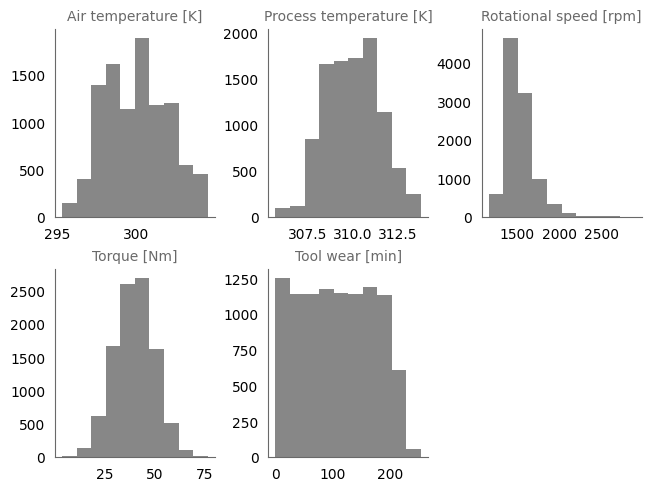

In [27]:
fig, axes = plt.subplots(
    nrows=2, ncols=3, constrained_layout=True, figsize=(6.4, 4.8))
i = 0
axes = axes.flatten()
for col in raw_df.select_dtypes(include=['number']).columns:
    axes[i].hist(raw_df[col], color='dimgray', alpha=0.8, label='')
    axes[i].set_title(col, fontsize=10, color='dimgray')
    i += 1

for ax in axes:
    ax.tick_params(bottom=False, left=False)
    ax.grid(False)
    ax.spines[['top', 'right']].set_visible(False)
    ax.spines[['left', 'bottom']].set_color('dimgray')
fig.delaxes(axes[5])

**Quantile–quantile plot**

* A graphical method for comparing two probability distributions by plotting their quantiles against each other.

* In this instance, we are comparing the 'rotational speed' when standardised to the standard normal distribution.

    * Blue: Ordered observed values vs corresponding z-scores
 
        $z_{actual} = \frac{x_{actual}-\bar{x}}{s}$

    * Red: Theoretical values vs theoretical z-scores
 
        $x_{theory} = z_{theory}s + \bar{x}$

        Note: A z score of 0 corresponds to the 50th percentile

* The distribution is not normal. Blue points do not lie on the red line and the y-intercept is not zero.

Additional notes:

* Theoretical quantiles (e.g. percentiles) may be plotted across the x-axis.

* For a standard normal distribution, percentiles can be calculated using the $68-95-99.7$ rule:

  <img src="./figures/percentiles_zscores.png" align="centre" width="350" />

* Note a q-q plot can be used to compare any two distributions. For non-normal distributions, the theoretical value of a random variable $X$ for a given percentile can be calculated using the inverse of its CDF:

    $F_X(x)=P(X\leq x)$

    $F^{-1}(p)=x$

    $F^{-1}(0.5)=x_{median}$
  
    *Where $F_X(x)$ is the CDF and its inverse $F^-1(p)$ is the quantile function.*

Text(0.5, 0, 'Theoretical quantiles')

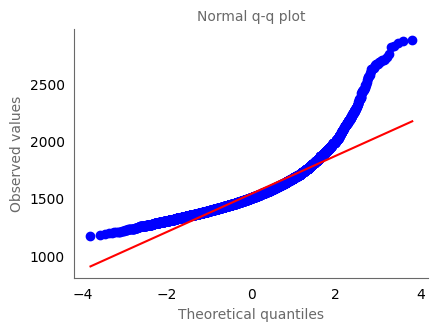

In [28]:
# Q-Q plot
fig, axes= plt.subplots(
    nrows=1, ncols=1, constrained_layout=True, figsize=(6.4/1.5, 4.8/1.5)
)
probplot(raw_df['Rotational speed [rpm]'], dist="norm", plot=axes)

axes.tick_params(bottom=False, left=False)
axes.grid(False)
axes.spines[['top', 'right']].set_visible(False)
axes.spines[['left', 'bottom']].set_color('dimgray')
axes.set_title('Normal q-q plot', fontsize=10, color='dimgray')
axes.set_ylabel('Observed values', fontsize=10, color='dimgray')
axes.set_xlabel('Theoretical quantiles', fontsize=10, color='dimgray')

**_2) Categorical variables_**
* No duplicate values are present in 'UDI' and 'Product ID'

* The distributions of 'Type', 'Target' and 'Failure Type' are imbalanced.

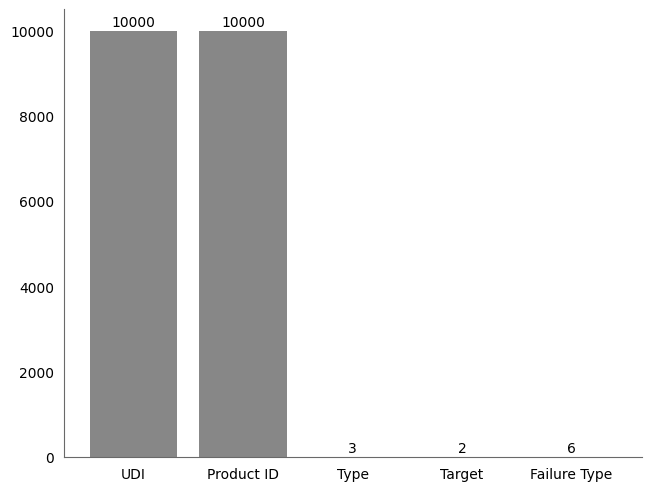

In [29]:
# Cardinality
fig, ax = plt.subplots(
    nrows=1, ncols=1, constrained_layout=True, figsize=(6.4, 4.8))
ax.tick_params(bottom=False, left=False)
ax.grid(False)
ax.spines[['top', 'right']].set_visible(False)
ax.spines[['left', 'bottom']].set_color('dimgray')

col_cardinality = raw_df.select_dtypes(include=['object', 'category']).nunique()
bars = ax.bar(col_cardinality.index, col_cardinality.values, color='dimgray', alpha=0.8)
ax.bar_label(bars, padding=1);

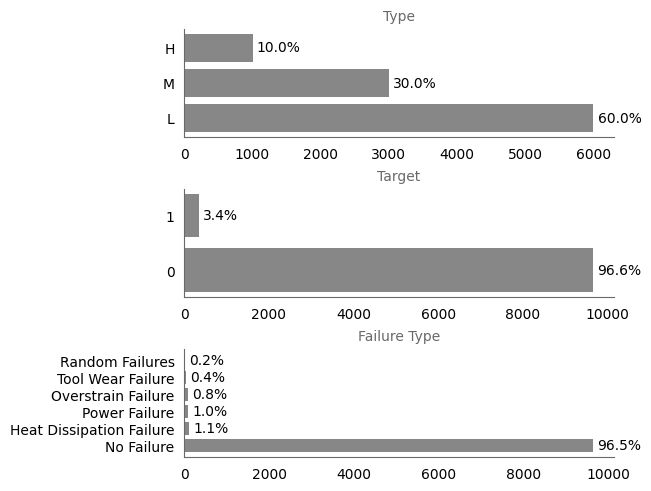

In [30]:
# Frequency plots
fig, axes = plt.subplots(
    nrows=3, ncols=1, constrained_layout=True, figsize=(6.4, 4.8)
)
i = 0
for col in ['Type', 'Target', 'Failure Type']:
    counts = raw_df[col].value_counts()
    percs = raw_df[col].value_counts(normalize=True)
    rects = axes[i].barh(counts.index, counts.values,
                         color='dimgray', alpha=0.8)
    axes[i].bar_label(rects, labels=[str(round(x*100, 1)) +
                      '%' for x in percs.values], padding=3)
    axes[i].set_title(col, fontsize=10, color='dimgray')
    i += 1
for ax in axes:
    ax.tick_params(bottom=False, left=False)
    ax.grid(False)
    ax.spines[['top', 'right']].set_visible(False)
    ax.spines[['left', 'bottom']].set_color('dimgray')

## Missing values
* No missing values are present.

In [31]:
# Identify columns with missing values
nan_summary = pd.concat(
    [raw_df.isnull().sum()[(raw_df.isnull().sum() > 1)],
     raw_df.isnull().sum()[(raw_df.isnull().sum() > 1)] / raw_df.shape[0]],
    axis=1, keys=['Count', '%']
)
display(nan_summary)

# Count rows with more than one missing value
rows_with_multiple_missing = raw_df[raw_df.isnull().sum(axis=1) > 1]
print(f"Number of rows with more than one missing value: {len(rows_with_multiple_missing)}")

,Count,%


Number of rows with more than one missing value: 0


# Data cleansing

## Erroneous data
* No duplicate rows are present.

* Data exploration did not reveal any errors.

In [32]:
raw_df[raw_df.duplicated()]

,UDI,Product ID,Type,Air temperature [K],Process temperature [K],Rotational speed [rpm],Torque [Nm],Tool wear [min],Target,Failure Type


## Train/test split
* The raw data is divided using an 80/20 train/test split.

In [33]:
# Divide train/test data
X_cols = [x for x in raw_df.columns if x != 'Target' and x!= 'Failure Type']
X_train, X_test, y_train, y_test = train_test_split(
    raw_df[X_cols], raw_df[['Target', 'Failure Type']], test_size=0.2, random_state=42
)
train_df = pd.concat([X_train, y_train], axis=1).reset_index(drop=True)
test_df = pd.concat([X_test, y_test], axis=1).reset_index(drop=True)

print(f'Train set dimensions: {train_df.shape}')
print(f'Test set dimensions: {test_df.shape}')

Train set dimensions: (8000, 10)
Test set dimensions: (2000, 10)


## Missing value imputation
* No missing values are present.

In [34]:
# Missing values in the training data
train_nan_summary = pd.concat([train_df.isnull().sum()[(train_df.isnull().sum() > 1)],
                               train_df.isnull().sum()[(train_df.isnull().sum() > 1)] / train_df.shape[0]],
                              axis=1, keys=['Count', '%']
                             )

# Missing values in the test data
test_nan_summary = pd.concat([test_df.isnull().sum()[(test_df.isnull().sum() > 1)],
                               test_df.isnull().sum()[(test_df.isnull().sum() > 1)] / test_df.shape[0]],
                              axis=1, keys=['Count', '%']
                             )
print(f'\n-----------------------------Missing values in training set-----------------------------')
display(train_nan_summary)
print(f'\n-----------------------------Missing values in test set-----------------------------')
display(test_nan_summary)


-----------------------------Missing values in training set-----------------------------


,Count,%



-----------------------------Missing values in test set-----------------------------


,Count,%


## Outliers
* The Rotational Speed column has a positive skew. However, no outliers are obviously present.

    Note: The influence of large values on later modelling will be assessed. If a point significantly affects outcomes, it may be excluded.

# Save
* Target will be dropped as the goal is to predict type of failure.

In [35]:
train_df = train_df.drop(columns='Target')
test_df = test_df.drop(columns='Target')

train_df.to_csv('../data/cleaned/clean_train.csv', index=False)
test_df.to_csv('../data/cleaned/clean_test.csv', index=False)